# Sarcasm Detector

#### The dataset
News Headlines dataset for Sarcasm Detection is collected from two news websites. TheOnion aims at producing sarcastic versions of current and humorous stories. While it may look like real news at a glance, everything they publish is intentionally fake. Real (and non-sarcastic) news headlines are collected from HuffPost.

Each record consists of three attributes:
- is_sarcastic: 1

- if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data


#### Import statements

In [ ]:
!pip install -U "transformers==4.44.2" "tokenizers==0.19.1"

In [27]:
import re
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns

from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import nltk
import contractions

from transformers import pipeline, DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
import evaluate
from evaluate import evaluator

nltk.download("punkt")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Function definitions

In [28]:
def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs

def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

def gen_prediction(model, x_test, y_test):
    predictions = model.predict(x_test, batch_size=2048, verbose=0).ravel()
    predictions = [1 if prob > 0.5 else 0 for prob in predictions]
    acc = accuracy_score(y_test, predictions)*100
    print(f"Accuracy: {acc:.2f}")
    print(classification_report(y_test, predictions))
    labels = ['not sarcastic', 'sarcastic']
    print(pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels))

    return acc

#### Get and Load Data

In [29]:
!gdown 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 179MB/s]


#### Import data

In [30]:
df = pd.read_json('./SarcasmDetect.json', lines=True)
df.sample(5)

,is_sarcastic,headline,article_link
6450,1,list of things man wants to do before he dies ...,https://entertainment.theonion.com/list-of-thi...
17239,1,prescription put in 2009 new year's eve glasses,https://local.theonion.com/prescription-put-in...
7338,0,the new 'batman v superman: dawn of justice' t...,https://www.huffingtonpost.com/entry/batman-su...
3232,1,family has extremely lax standards for who get...,https://local.theonion.com/family-has-extremel...
19162,0,wwii veteran reunites with his long-lost love ...,https://www.huffingtonpost.comhttp://pubx.co/L...


#### Remove all records with no headline text

In [31]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


Define X and y

In [32]:
corpus = df['headline']
y = df['is_sarcastic']

In [33]:
y.value_counts(normalize=True)

,proportion
is_sarcastic,
0,0.523603
1,0.476397


## Text preprocessing

#### Normalize corpus

In [34]:
corpus_clean = normalize_corpus(corpus)

100%|██████████| 28619/28619 [00:00<00:00, 32563.92it/s]


#### Train-test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(corpus_clean, y, test_size=0.3, random_state=42)

#### TF-IDF vectorizer

In [36]:
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2))
tv_xtrain = tv.fit_transform(X_train)
tv_xtest = tv.transform(X_test)

## ML models

### Baseline logistic regression

In [37]:
# instantiate model
model_lr = LogisticRegression(penalty='l2', max_iter=500, C=1,
                        solver='lbfgs', random_state=42)

In [38]:
model_lr.fit(tv_xtrain, y_train.values)
tfidf_predictions_lr = model_lr.predict(tv_xtest)

In [39]:
labels = ['not sarcastic', 'sarcastic']
acc_lr = accuracy_score(y_test, tfidf_predictions_lr)*100
print(classification_report(y_test, tfidf_predictions_lr))
pd.DataFrame(confusion_matrix(y_test, tfidf_predictions_lr), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4455
           1       0.82      0.83      0.83      4131

    accuracy                           0.83      8586
   macro avg       0.83      0.83      0.83      8586
weighted avg       0.83      0.83      0.83      8586



,not sarcastic,sarcastic
not sarcastic,3712,743
sarcastic,702,3429


### Random forest model

In [40]:
# instantiate model
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# train model
model_rf.fit(tv_xtrain, y_train)

# predict on test data
tfidf_predictions_rf = model_rf.predict(tv_xtest)

In [41]:
labels = ['not sarcastic', 'sarcastic']
acc_rf = accuracy_score(y_test, tfidf_predictions_rf)*100
print(classification_report(y_test, tfidf_predictions_rf))
pd.DataFrame(confusion_matrix(y_test, tfidf_predictions_rf), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      4455
           1       0.78      0.82      0.80      4131

    accuracy                           0.80      8586
   macro avg       0.80      0.80      0.80      8586
weighted avg       0.80      0.80      0.80      8586



,not sarcastic,sarcastic
not sarcastic,3469,986
sarcastic,727,3404


### XGBoost

In [42]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

In [43]:
model_xgb.fit(tv_xtrain, y_train)
predictions_xgb = model_xgb.predict(tv_xtest)

In [44]:
labels = ['not sarcastic', 'sarcastic']
acc_xgb = accuracy_score(y_test, predictions_xgb)*100
print(classification_report(y_test, predictions_xgb))
pd.DataFrame(confusion_matrix(y_test, predictions_xgb), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.84      0.74      0.78      4455
           1       0.75      0.84      0.79      4131

    accuracy                           0.79      8586
   macro avg       0.79      0.79      0.79      8586
weighted avg       0.79      0.79      0.79      8586



,not sarcastic,sarcastic
not sarcastic,3288,1167
sarcastic,643,3488


## Deep learning models
### Preprocess text for DL models

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


In [46]:
# Tokenize sequences
t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=22132
Number of Documents=20033


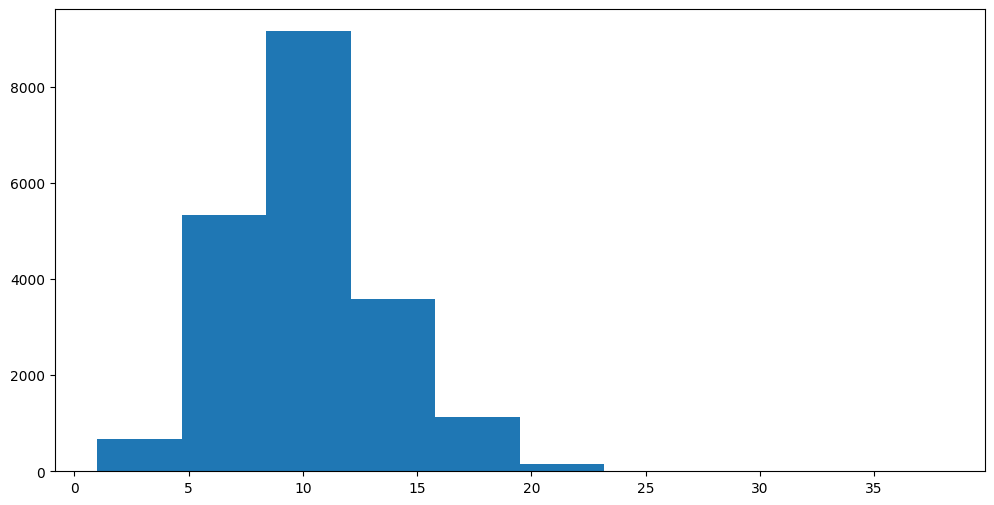

In [47]:
# Visualise length of each sequence
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
h1 = ax.hist(train_lens)

In [48]:
# Pad sequences to sensible length observed in plt
MAX_SEQUENCE_LENGTH = 23
X_train_pad = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,  padding='post')
X_train_pad.shape, X_test_pad.shape

((20033, 23), (8586, 23))

In [49]:
# Parameters for embedding layer
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300 # word embedding size

#### Training parameters

In [50]:
# Parameters for model training
EPOCHS=20
BATCH_SIZE=128

# Callback for early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

### CNN

In [51]:
# create the model
model_cnn = Sequential(name='CNN')

model_cnn.add(Embedding(VOCAB_SIZE,
                    EMBED_SIZE,
                    input_length=MAX_SEQUENCE_LENGTH))

model_cnn.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Flatten())

model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.25))
model_cnn.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.25))

model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Fit the model
model_cnn.fit(X_train_pad, y_train,
          validation_split=0.2,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[es],
          verbose=1)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7633 - loss: 0.4592 - val_accuracy: 0.8520 - val_loss: 0.3451
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9440 - loss: 0.1485 - val_accuracy: 0.8508 - val_loss: 0.3730
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0266 - val_accuracy: 0.8440 - val_loss: 0.5151
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.8408 - val_loss: 0.7082
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.8425 - val_loss: 0.8318
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9989 - loss: 0.0026 - val_accuracy: 0.8320 - val_loss: 1.1483
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [53]:
acc_cnn = gen_prediction(model_cnn, X_test_pad, y_test)

Accuracy: 84.50
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4455
           1       0.82      0.87      0.84      4131

    accuracy                           0.84      8586
   macro avg       0.85      0.85      0.84      8586
weighted avg       0.85      0.84      0.85      8586

               not sarcastic  sarcastic
not sarcastic           3649        806
sarcastic                525       3606


#### Use FastText embedding

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [54]:
import gensim.downloader as api
ft_model = api.load("fasttext-wiki-news-subwords-300")

In [66]:
word2idx = t.word_index


In [67]:
ft_embeddings = load_pretrained_embeddings(
    word_to_index=word2idx,
    max_features=VOCAB_SIZE,
    embedding_size=EMBED_SIZE,
    ft_model=ft_model
)

ft_embeddings.shape

(22132, 300)

In [68]:
model_cnn_ft = tf.keras.models.Sequential(name='CNN-FastText')

model_cnn_ft.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn_ft.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model_cnn_ft.add(tf.keras.layers.Flatten())

model_cnn_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_ft.add(tf.keras.layers.Dropout(0.25))
model_cnn_ft.add(tf.keras.layers.Dense(256, activation='relu'))
model_cnn_ft.add(tf.keras.layers.Dropout(0.25))
model_cnn_ft.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn_ft.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_ft.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "CNN-FastText"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,639,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,639,600 (25.33 MB)

 Trainable params: 6,639,600 (25.33 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model_cnn_ft.fit(X_train_pad, y_train,
          validation_split=0.2,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=[es],
          verbose=1)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7903 - loss: 0.4270 - val_accuracy: 0.8592 - val_loss: 0.3269
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9459 - loss: 0.1510 - val_accuracy: 0.8655 - val_loss: 0.3401
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9881 - loss: 0.0350 - val_accuracy: 0.8627 - val_loss: 0.5463
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9944 - loss: 0.0159 - val_accuracy: 0.8650 - val_loss: 0.6637
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.8630 - val_loss: 0.8667
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.8508 - val_loss: 0.9504
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [70]:
acc_cnn_ft = gen_prediction(model_cnn_ft, X_test_pad, y_test)

Accuracy: 85.73
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4455
           1       0.90      0.79      0.84      4131

    accuracy                           0.86      8586
   macro avg       0.86      0.85      0.86      8586
weighted avg       0.86      0.86      0.86      8586

               not sarcastic  sarcastic
not sarcastic           4110        345
sarcastic                880       3251


### LSTM

In [71]:
LSTM_DIM = 128 # the number of hidden units in each LSTM cell i.e the hidden state embedding size;

model_lstm = tf.keras.models.Sequential(name="LSTM")

model_lstm.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))) # to use bidirectional lstms

# model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_lstm.add(tf.keras.layers.Dense(256, activation='relu'))

model_lstm.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_lstm.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     6,639,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,639,600 (25.33 MB)

 Trainable params: 6,639,600 (25.33 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model_lstm.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[es],
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8195 - loss: 0.3972 - val_accuracy: 0.8410 - val_loss: 0.3673
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9400 - loss: 0.1592 - val_accuracy: 0.8590 - val_loss: 0.3582
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9780 - loss: 0.0615 - val_accuracy: 0.8450 - val_loss: 0.4458
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9910 - loss: 0.0289 - val_accuracy: 0.8390 - val_loss: 0.6314
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9967 - loss: 0.0120 - val_accuracy: 0.8418 - val_loss: 0.9129
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [73]:
acc_lstm = gen_prediction(model_lstm, X_test_pad, y_test)

Accuracy: 83.86
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4455
           1       0.77      0.94      0.85      4131

    accuracy                           0.84      8586
   macro avg       0.85      0.84      0.84      8586
weighted avg       0.85      0.84      0.84      8586

               not sarcastic  sarcastic
not sarcastic           3327       1128
sarcastic                258       3873


### GRU

In [74]:
GRU_DIM = 1024 # the number of hidden units in each LSTM cell i.e the hidden state embedding size;

model_gru = tf.keras.models.Sequential(name="GRU")

model_gru.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))
model_gru.add(tf.keras.layers.Dropout(0.5))

model_gru.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM, return_sequences=True))) # to use bidirectional lstms
model_gru.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM, return_sequences=False))) # to use bidirectional lstms

# model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model_gru.add(tf.keras.layers.Dense(256, activation='relu'))
# model_gru.add(tf.keras.layers.Dropout(0.2))
model_gru.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_gru.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model_gru.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     6,639,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,639,600 (25.33 MB)

 Trainable params: 6,639,600 (25.33 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model_gru.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.8009 - loss: 0.4185 - val_accuracy: 0.8508 - val_loss: 0.3275
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.9128 - loss: 0.2160 - val_accuracy: 0.8538 - val_loss: 0.3764
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.9571 - loss: 0.1132 - val_accuracy: 0.8603 - val_loss: 0.3479
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.9766 - loss: 0.0629 - val_accuracy: 0.8493 - val_loss: 0.4870
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.9873 - loss: 0.0341 - val_accuracy: 0.8498 - val_loss: 0.5626
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [76]:
acc_gru = gen_prediction(model_gru, X_test_pad, y_test)

Accuracy: 85.93
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4455
           1       0.82      0.90      0.86      4131

    accuracy                           0.86      8586
   macro avg       0.86      0.86      0.86      8586
weighted avg       0.86      0.86      0.86      8586

               not sarcastic  sarcastic
not sarcastic           3650        805
sarcastic                403       3728


## Transformers

### BERT

In [77]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        # with newer versions of transformers you don't need to explicitely add CLS and SEP
        # they are automatically added by the tokenizer
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [78]:
import transformers

In [79]:
import tqdm

In [80]:
# Tokenize
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(corpus_clean, y, train_size=0.7, random_state=42)

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [81]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               X_train,
                                                                                               max_seq_length=MAX_SEQUENCE_LENGTH)

test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                               X_test,
                                                                                               max_seq_length=MAX_SEQUENCE_LENGTH)

Converting docs to features: 100%|██████████| 8586/8586 [00:01<00:00, 4614.22it/s]


In [82]:
# Build BERT model
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

inp_id = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

def bert_layer(inputs):
    return bert_model(input_ids=inputs[0], attention_mask=inputs[1], token_type_ids=inputs[2])

bert_outputs = tf.keras.layers.Lambda(bert_layer, output_shape=(MAX_SEQUENCE_LENGTH, 768))([inp_id, inp_mask, inp_segment])

pooled_output = bert_outputs[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_bert = tf.keras.Model(inputs=[inp_id, inp_mask, inp_segment], outputs=output)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model_bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bert_input_ids      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_masks    │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_segment_ids    │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 23, 768)   │          0 │ bert_input_ids[0… │
│                     │                   │            │ bert_input_masks… │
│                     │                   │            │ bert_segment_ids… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (23, 768)         │          0 │ lambda_1[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (23, 256)         │    196,864 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (23, 256)         │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (23, 256)         │     65,792 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (23, 256)         │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (23, 1)           │        257 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 262,913 (1.00 MB)

 Trainable params: 262,913 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model_bert.fit([train_features_ids,
           train_features_masks,
           train_features_segments], y_train,
           validation_split=0.2, epochs=20,
           batch_size=15,
           shuffle=True,
           verbose=1)

Epoch 1/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 60s 40ms/step - accuracy: 0.5904 - loss: 0.6689 - val_accuracy: 0.7265 - val_loss: 0.6060
Epoch 2/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.6911 - loss: 0.5980 - val_accuracy: 0.7489 - val_loss: 0.5466
Epoch 3/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7248 - loss: 0.5569 - val_accuracy: 0.7652 - val_loss: 0.5221
Epoch 4/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7426 - loss: 0.5297 - val_accuracy: 0.7654 - val_loss: 0.5019
Epoch 5/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7541 - loss: 0.5142 - val_accuracy: 0.7692 - val_loss: 0.4904
Epoch 6/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.7600 - loss: 0.5009 - val_accuracy: 0.7839 - val_loss: 0.4751
Epoch 7/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7652 - loss: 0.4889 - val_accuracy: 0.7884 - val_loss: 0.4639
Epoch 8/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7708 -

In [84]:
acc_bert = gen_prediction(model_bert, [test_features_ids,
           test_features_masks,
           test_features_segments], y_test)

Accuracy: 80.10
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      4455
           1       0.83      0.74      0.78      4131

    accuracy                           0.80      8586
   macro avg       0.80      0.80      0.80      8586
weighted avg       0.80      0.80      0.80      8586

               not sarcastic  sarcastic
not sarcastic           3819        636
sarcastic               1073       3058


## Visualise results

In [85]:
acc_list = [acc_lr, acc_rf, acc_xgb, acc_cnn, acc_cnn_ft, acc_lstm, acc_gru, acc_bert]
acc_labels = ["LogisticRegression", "RandomForest", "XGBoost", "CNN", "CNNFastText", "LSTM", "GRU", "BERT"]
acc_dict = {k: v for k, v in zip(acc_labels, acc_list)}
df_acc = pd.DataFrame(acc_dict, index=range(0, 1)).melt()

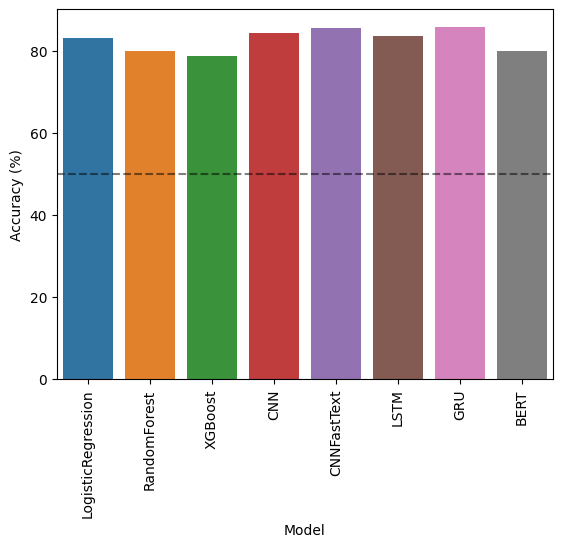

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.barplot(df_acc, x="variable", y="value", hue="variable")
ax.set_xticks(acc_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.axhline(50, linestyle="--", color="k", alpha=0.5)
None